In [2]:
import pandas as pd
import numpy as np
import math
import string
import copy
import tensorflow as tf
from gensim import models
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import StratifiedKFold
from tensorflow_addons.metrics import F1Score
from collections import Counter
from tqdm import tqdm
import warnings
import os
import pathlib
warnings.filterwarnings("ignore")

In [21]:
test_folds = {}

In [22]:
stfold = StratifiedKFold(n_splits=5, shuffle=True)
train_l = list()
val_l = list()
test_l = list()
maxlen = 100
cnt = 0
for train_index, test_index in stfold.split(data['comment'], data['label']):
    cnt += 1
    train = data.iloc[train_index]
    train_x, train_y = train['comment'], train['label']
    tmp = data.iloc[test_index]

    val, test = train_test_split(tmp, test_size=0.5, stratify=tmp['label'])    
    val_x, val_y = val['comment'], val['label']
    test_x, test_y = test['comment'], test['label']    
    
    train_x = vectorizer(np.array([[s] for s in train_x])).numpy()    
    val_x = vectorizer(np.array([[s] for s in val_x])).numpy()
    test_x = vectorizer(np.array([[s] for s in test_x])).numpy()

    train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=maxlen)
    val_x = keras.preprocessing.sequence.pad_sequences(val_x, maxlen=maxlen)
    test_x = keras.preprocessing.sequence.pad_sequences(test_x, maxlen=maxlen)
    
    test_folds[cnt] = (test_x, test_y)
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = layers.Embedding(input_dim = vocab_size, 
                                       output_dim = emb_dim, 
                                       embeddings_initializer=keras.initializers.Constant(matrix),
                                       trainable=True)
    x = embedding_layer(inputs)
    x = layers.Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.concatenate([avg_pool, max_pool])
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model_path = "logistic_models/{itr:04}".format(itr=cnt)
    checkpoint_path = model_path + "-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    !mkdir logistic_models
    !mkdir $model_path
    
    model.compile(tf.optimizers.Adam(lr=0.001), "binary_crossentropy", metrics=[  "accuracy", 
                                                                                  tf.keras.metrics.AUC(name='auc')])
    
    
    #create checkpoint to save model
    #with best validation loss
    model.save_weights(checkpoint_path.format(epoch=0))

    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_auc', verbose=1,
            save_weights_only=True, save_best_only=True, mode='max')
    
    history = model.fit(
                        train_x, train_y, 
                        batch_size=128, epochs=10, 
                        validation_data=(val_x, val_y),
                        callbacks = [checkpoint]
                        )
    
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)
    
    train_eval = model.evaluate(train_x, train_y)
    val_eval = model.evaluate(val_x, val_y)
    test_eval = model.evaluate(test_x, test_y)
    
    test_l.append(test_eval)
    val_l.append(val_eval)
    train_l.append(train_eval)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.5803 - auc: 0.6300
Epoch 00001: val_auc improved from -inf to 0.76021, saving model to logistic_models/0001-0001.ckpt
63/63 [==============================] - 12s 192ms/step - loss: 0.6703 - accuracy: 0.5803 - auc: 0.6300 - val_loss: 0.6262 - val_accuracy: 0.6660 - val_auc: 0.7602
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.4142 - accuracy: 0.8640 - auc: 0.9501
Epoch 00002: val_auc improved from 0.76021 to 0.92177, saving model to logistic_models/0001-0002.ckpt
63/63 [==============================] - 12s 187ms/step - loss: 0.4142 - accuracy: 0.8640 - auc: 0.9501 - val_loss: 0.3525 - val_accuracy: 0.8470 - val_auc: 0.9218
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.0992 - accuracy: 0.9759 - auc: 0.9960
Epoch 00003: val_auc improved from 0.92177 to 0.93528, saving model to logistic_models/0001-0003.ckpt
63/63 [==============================] - 11s 

In [23]:
test_l = np.array(test_l)
val_l = np.array(val_l)
train_l = np.array(train_l)

print("test avg loss: ", np.mean(test_l[:, 0]), "+/-" ,np.std(test_l[:, 0]))
print("test avg acc: ", np.mean(test_l[:, 1]),  "+/-" ,np.std(test_l[:, 1]))
print("test avg auc: ", np.mean(test_l[:, 2]),  "+/-" ,np.std(test_l[:, 2]))
print('\n')


print("val avg loss: ", np.mean(val_l[:, 0]), "+/-" ,np.std(val_l[:, 0]))
print("val avg acc: ", np.mean(val_l[:, 1]),  "+/-" ,np.std(val_l[:, 1]))
print("val avg auc: ", np.mean(val_l[:, 2]),  "+/-" ,np.std(val_l[:, 2]))

print('\n')


print("train avg loss: ", np.mean(train_l[:, 0]), "+/-" ,np.std(train_l[:, 0]))
print("train avg acc: ", np.mean(train_l[:, 1]),  "+/-" ,np.std(train_l[:, 1]))
print("train avg auc: ", np.mean(train_l[:, 2]),  "+/-" ,np.std(train_l[:, 2]))

test avg loss:  0.3083700895309448 +/- 0.01444668987174623
test avg acc:  0.8833999991416931 +/- 0.007059749382263934
test avg auc:  0.9362534999847412 +/- 0.002577454126211303


val avg loss:  0.3190665304660797 +/- 0.013388349821097318
val avg acc:  0.8778000116348267 +/- 0.005153630504736538
val avg auc:  0.9371911883354187 +/- 0.0016170609897591095


train avg loss:  0.018835604656487703 +/- 0.011275637328383733
train avg acc:  0.9975000143051147 +/- 0.0015870574830088933
train avg auc:  0.9996532678604126 +/- 0.00028086008005942834


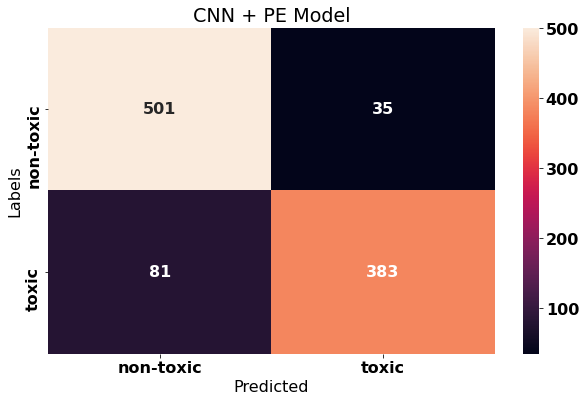

In [24]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd 
from sklearn.metrics import confusion_matrix

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
pred = np.array([model.predict(test_folds[5][0]) > 0.5], dtype=int).ravel()
cm = confusion_matrix(test_folds[5][1].values, pred)
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10, 6))

sns.heatmap(cm,
            fmt = 'd',
            annot=True)


ax = plt.subplot()
ax.set_xlabel('Predicted')
ax.set_ylabel('Labels')
ax.xaxis.set_ticklabels(['non-toxic', 'toxic'])
ax.yaxis.set_ticklabels(['non-toxic', 'toxic'])
ax.set_title('CNN + PE Model')
plt.show()